# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [4]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy import fftpack
import torch
import pandas as pd
import zipfile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')
import vtk
from vtk.util import numpy_support as vn

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_30326/510595696.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


torch device: cpu


In [5]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.1'

### Style settings

In [6]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [3]:
def power_spec_graph_func(fig, axarr, data_path, param_str, label_str,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0,0].sharey(axarr[0,1])
        axarr[0,0].sharex(axarr[0,1])
        axarr[1,0].sharex(axarr[1,1])
        axarr[1,0].sharey(axarr[1,1])

        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        # Make color scale
        log_pvs = np.log10(param_vals)
        norm_log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(norm_log_pvs)

        avg_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                power_spec = cps.power_spec(com_arr, device)
                n_ps_pos_vals = int(power_spec.size(dim=0)/2)
                freq = torch.fft.fftfreq(power_spec.size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

                _ = axarr[0, 0].plot(freq, power_spec.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[1, 0].plot(freq, power_spec.imag.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)

                power_spec_list += [power_spec[:n_ps_pos_vals]]

            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(axis=0)]
            # std_auto_corr_list += [power_spec_mat.std(axis=0)]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
            
            # Make sure you get the right scale of the frequency array
            #   Nyquist frequency should be 1/(2 * \Delta t)
            # n_ps_pos_vals = int(avg_power_spec_list[-1].size(dim=0)/2)
            # freq_arr = torch.fft.fftfreq(avg_power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

            _ = axarr[0, 1].plot(freq, avg_power_spec_list[-1].real.to('cpu'),
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[1, 1].plot(freq, avg_power_spec_list[-1].imag.to('cpu'),
                                 color=colors[i], label=f"$ k_o = {label}$")
        
        _ = axarr[0,0].set_ylabel('Real power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[1,0].set_ylabel('Imaginary power spectrum \n' + r'Im$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[0,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,0].set_yscale('log')
        _ = axarr[0,0].set_xscale('log')
        _ = axarr[1,0].set_yscale('log')
        _ = axarr[1,0].set_xscale('log')

        _ = axarr[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [5]:
def resp_graph_func(fig, axarr, data_path, param_str, label_str,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0,0].sharey(axarr[0,1])
        axarr[0,0].sharex(axarr[0,1])
        axarr[1,0].sharex(axarr[1,1])
        axarr[1,0].sharey(axarr[1,1])
        axarr[2,0].sharex(axarr[2,1])
        axarr[2,0].sharey(axarr[2,1])

        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        # Make color scale
        log_pvs = np.log10(param_vals)
        norm_log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(norm_log_pvs)

        avg_iresp_list = []
        avg_rresp_list = []
        avg_theta_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            iresp_list = []
            rresp_list = []
            theta_list = []
            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                iresp, freq_arr = cps.imag_poly_response_func(com_arr, time_arr[2]-time_arr[1], device=device)
                n_ps_pos_vals = int(iresp.size(dim=0)/2)
                freq_arr = freq_arr[:n_ps_pos_vals].cpu()
                iresp = iresp[:n_ps_pos_vals]
                rresp = torch.from_numpy(cps.real_poly_response_func(iresp.cpu()[:n_ps_pos_vals])).to(device)
                theta = iresp/rresp
                # freq = torch.fft.fftfreq(iresp.size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

                # _ = axarr[0, 0].plot(freq, iresp.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[0, 0].plot(freq_arr, rresp.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[1, 0].plot(freq_arr, iresp.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[2, 0].plot(freq_arr, theta.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)

                # Only store positive values for the purpose of graphing
                rresp_list += [rresp[:n_ps_pos_vals]]
                iresp_list += [iresp[:n_ps_pos_vals]]
                theta_list += [theta[:n_ps_pos_vals]]

            # min_length = min([len(avg) for avg in iresp_list])
            rresp_mat = torch.stack([avg for avg in rresp_list])
            iresp_mat = torch.stack([avg for avg in iresp_list])
            theta_mat = torch.stack([avg for avg in theta_list])
            
            avg_rresp_list += [rresp_mat.mean(axis=0)]
            avg_iresp_list += [iresp_mat.mean(axis=0)]
            avg_theta_list += [theta_mat.mean(axis=0)]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
            
            # Make sure you get the right scale of the frequency array
            #   Nyquist frequency should be 1/(2 * \Delta t)
            # n_avg_pos_vals = int(avg_iresp_list[-1][:].size(dim=0)/2)
            # freq_arr = torch.fft.fftfreq(avg_iresp_list[-1][:].size(dim=0), time_arr[2]-time_arr[1])[:n_avg_pos_vals]

            # _ = axarr[0, 1].plot(freq_arr, avg_iresp_list[-1].real.to('cpu')[:n_avg_pos_vals], 
                                #  color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[0, 1].plot(freq_arr, avg_rresp_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[1, 1].plot(freq_arr, avg_iresp_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[2, 1].plot(freq_arr, avg_theta_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                                 color=colors[i], label=f"{label_str}$= {label}$")
        
        _ = axarr[0,0].set_ylabel('Real response function\n' + r"$\alpha'$")
        _ = axarr[1,0].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{2kT}$")
        _ = axarr[2,0].set_ylabel('Phase lag ' + r"$\tan(\delta) = \frac{\alpha''}{\alpha'}$" )
        _ = axarr[0,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[2,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[2,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')

        _ = axarr[0,0].set_yscale('log')
        _ = axarr[0,0].set_xscale('log')
        _ = axarr[1,0].set_yscale('log')
        _ = axarr[1,0].set_xscale('log')
        # _ = axarr[2,0].set_yscale('log')
        _ = axarr[2,0].set_xscale('log')
        _ = axarr[2,0].set_ylim(-1.2, 5.2)

        _ = axarr[1,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [6]:
def resp_graph_ci_func(fig, axarr, data_path, param_str, label_str,
                        ci_bound=.95,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0].sharex(axarr[1])
        axarr[1].sharex(axarr[2])

        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        # Make color scale
        log_pvs = np.log10(param_vals)
        norm_log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(norm_log_pvs)

        avg_iresp_list = []
        avg_rresp_list = []
        avg_theta_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            iresp_list = []
            rresp_list = []
            theta_list = []
            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                iresp, freq_arr = cps.imag_poly_response_func(com_arr, time_arr[2]-time_arr[1], device=device)
                n_ps_pos_vals = int(iresp.size(dim=0)/2)
                freq_arr = freq_arr[:n_ps_pos_vals].cpu()
                iresp = iresp[:n_ps_pos_vals]
                rresp = torch.from_numpy(cps.real_poly_response_func(iresp.cpu()[:n_ps_pos_vals])).to(device)
                theta = iresp/rresp

                # Only store positive values for the purpose of graphing
                rresp_list += [rresp[:n_ps_pos_vals]]
                iresp_list += [iresp[:n_ps_pos_vals]]
                theta_list += [theta[:n_ps_pos_vals]]

            # min_length = min([len(avg) for avg in iresp_list])
            rresp_mat = torch.stack([avg for avg in rresp_list])
            iresp_mat = torch.stack([avg for avg in iresp_list])
            theta_mat = torch.stack([avg for avg in theta_list])

            ci_rr = (rresp_mat.real.std(axis=0)/np.sqrt(len(rresp_list)) *
                  (np.sqrt(2)*erfinv(ci_bound))).cpu()
            ci_ir = (iresp_mat.real.std(axis=0)/np.sqrt(len(iresp_list)) *
                  (np.sqrt(2)*erfinv(ci_bound))).cpu()
            ci_theta = (theta_mat.real.std(axis=0)/np.sqrt(len(theta_list)) *
                  (np.sqrt(2)*erfinv(ci_bound))).cpu()
            
            avg_rresp_list += [rresp_mat.mean(axis=0)]
            avg_iresp_list += [iresp_mat.mean(axis=0)]
            avg_theta_list += [theta_mat.mean(axis=0)]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
            
            # Make sure you get the right scale of the frequency array
            #   Nyquist frequency should be 1/(2 * \Delta t)
            # n_avg_pos_vals = int(avg_iresp_list[-1][:].size(dim=0)/2)
            # freq_arr = torch.fft.fftfreq(avg_iresp_list[-1][:].size(dim=0), time_arr[2]-time_arr[1])[:n_avg_pos_vals]

            # _ = axarr[0, 1].plot(freq_arr, avg_iresp_list[-1].real.to('cpu')[:n_avg_pos_vals], 
                                #  color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[0].plot(freq_arr, avg_rresp_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                              color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[0].fill_between(freq_arr, 
                                      avg_rresp_list[-1].real.to('cpu')[:n_ps_pos_vals]-ci_rr.real, 
                                      avg_rresp_list[-1].real.to('cpu')[:n_ps_pos_vals]+ci_rr.real,
                                      color=colors[i], alpha=.25)
            _ = axarr[1].plot(freq_arr, avg_iresp_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                              color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[1].fill_between(freq_arr, 
                                      avg_iresp_list[-1].real.to('cpu')[:n_ps_pos_vals]-ci_ir.real, 
                                      avg_iresp_list[-1].real.to('cpu')[:n_ps_pos_vals]+ci_ir.real,
                                      color=colors[i], alpha=.25)
            _ = axarr[2].plot(freq_arr, avg_theta_list[-1].real.to('cpu')[:n_ps_pos_vals], 
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[2].fill_between(freq_arr, 
                                      avg_theta_list[-1].real.to('cpu')[:n_ps_pos_vals]-ci_theta.real, 
                                      avg_theta_list[-1].real.to('cpu')[:n_ps_pos_vals]+ci_theta.real,
                                      color=colors[i], alpha=.25)
        
        _ = axarr[0].set_ylabel('Real response function\n' + r"$\alpha'$")
        _ = axarr[1].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{2kT}$")
        _ = axarr[2].set_ylabel('Phase lag ' + r"$\tan(\delta) = \frac{\alpha''}{\alpha'}$" )
        _ = axarr[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[2].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')

        _ = axarr[0].set_yscale('log')
        _ = axarr[1].set_yscale('log')
        _ = axarr[2].set_xscale('log')
        _ = axarr[2].set_ylim(-1.2, 5.2)

        _ = axarr[2].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [7]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

# Read data

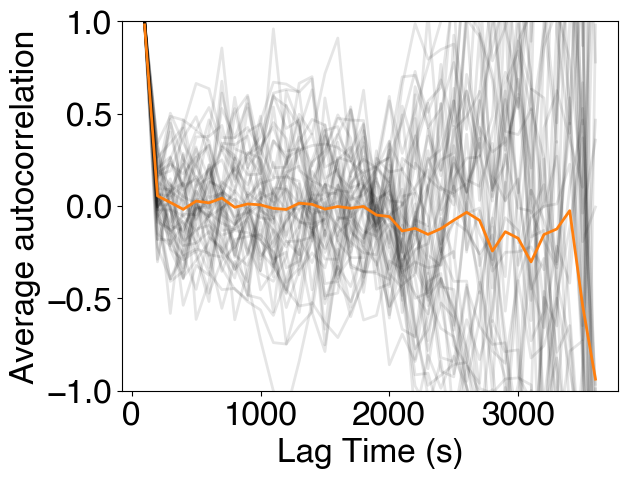

In [54]:
data_path = Path.home() / 'Desktop/chromatin_mobility_data_Binyam.xlsx'
# Read in an excel file as a torch tensor
data = pd.read_excel(data_path, sheet_name='Chromatin spots AccuDis DMSO', header=0)

time_arr = torch.from_numpy(data['Time'].values[2:].astype(np.float64))
corr_avg = torch.zeros_like(time_arr[1:])
n_cells = 50
for n in range(1, n_cells):
    accu_arr = torch.from_numpy(data.iloc[2:,n].values.astype(np.float64))
    disp_arr = accu_arr[1:] - accu_arr[:-1]
    disp_mat = torch.einsum('i,j->ij', disp_arr, disp_arr)
    corr_arr = torch.zeros_like(disp_arr)
    for i in range(0, disp_mat.size(0)):
        corr_arr[i] = disp_mat.diag(i).mean()

    corr_arr = corr_arr[:]-torch.pow(disp_arr.mean(), 2)
    corr_arr = corr_arr/corr_arr[0]
    _ = plt.plot(time_arr[1:], corr_arr, alpha=.1, color='k')
    corr_avg += corr_arr

corr_avg /= n_cells

_ = plt.plot(time_arr[1:], corr_avg, color='tab:orange')
_ = plt.ylabel('Average autocorrelation')
_ = plt.xlabel('Lag Time (s)')
_ = plt.ylim(-.5, .5)
_ = plt.ylim(-1, 1)
# _ = plt.yscale('log')
# _ = plt.xscale('log')
# _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

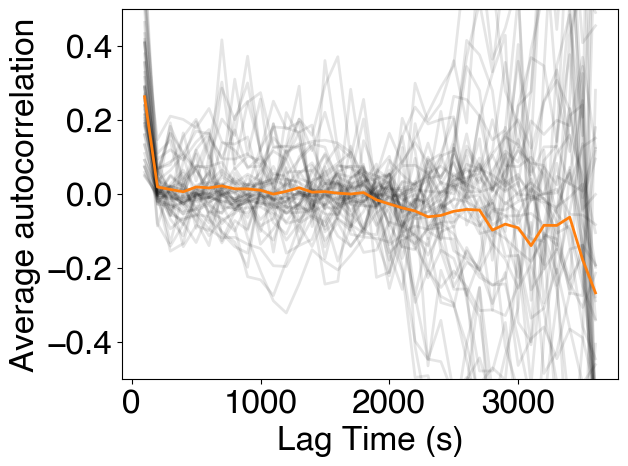

In [55]:
data_path = Path.home() / 'Desktop/chromatin_mobility_data_Binyam.xlsx'
# Read in an excel file as a torch tensor
data = pd.read_excel(data_path, sheet_name='Chromatin spots AccuDis DMSO', header=0)

time_arr = torch.from_numpy(data['Time'].values[2:].astype(np.float64))
corr_avg = torch.zeros_like(time_arr[1:])
n_cells = 50
for n in range(1, n_cells):
    accu_arr = torch.from_numpy(data.iloc[2:,n].values.astype(np.float64))
    disp_arr = accu_arr[1:] - accu_arr[:-1]
    disp_mat = torch.einsum('i,j->ij', disp_arr, disp_arr)
    corr_arr = torch.zeros_like(disp_arr)
    for i in range(0, disp_mat.size(0)):
        corr_arr[i] = disp_mat.diag(i).mean()

    corr_arr = corr_arr[:]-torch.pow(disp_arr.mean(), 2)
    # corr_arr = corr_arr/corr_arr[0]
    _ = plt.plot(time_arr[1:], corr_arr, alpha=.1, color='k')
    corr_avg += corr_arr

corr_avg /= n_cells

_ = plt.plot(time_arr[1:], corr_avg, color='tab:orange')
_ = plt.ylabel('Average autocorrelation')
_ = plt.xlabel('Lag Time (s)')
_ = plt.ylim(-.5, .5)
# _ = plt.ylim(-1, 1)
# _ = plt.yscale('log')
# _ = plt.xscale('log')
# _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

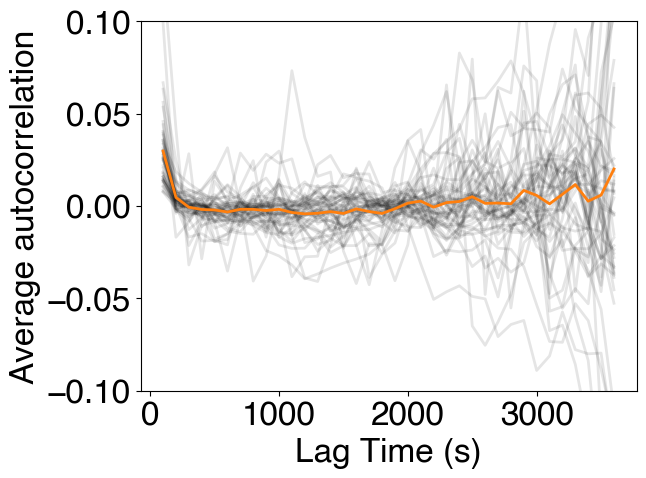

In [64]:
data_path = Path.home() / 'Desktop/chromatin_mobility_data_Binyam.xlsx'
# Read in an excel file as a torch tensor
data = pd.read_excel(data_path, sheet_name='Chromatin spots AccuDis CytoD', header=0)

time_arr = torch.from_numpy(data['Time'].values[2:].astype(np.float64))
corr_avg = torch.zeros_like(time_arr[1:])
n_cells = 50
for n in range(1, n_cells):
    accu_arr = torch.from_numpy(data.iloc[2:,n].values.astype(np.float64))
    disp_arr = accu_arr[1:] - accu_arr[:-1]
    disp_mat = torch.einsum('i,j->ij', disp_arr, disp_arr)
    corr_arr = torch.zeros_like(disp_arr)
    for i in range(0, disp_mat.size(0)):
        corr_arr[i] = disp_mat.diag(i).mean()

    corr_arr = corr_arr[:]-torch.pow(disp_arr.mean(), 2)
    # corr_arr = corr_arr/corr_arr[0]
    _ = plt.plot(time_arr[1:], corr_arr, alpha=.1, color='k')
    corr_avg += corr_arr

corr_avg /= n_cells

_ = plt.plot(time_arr[1:], corr_avg, color='tab:orange')
_ = plt.ylabel('Average autocorrelation')
_ = plt.xlabel('Lag Time (s)')
_ = plt.ylim(-.1, .1)
# _ = plt.ylim(-1, 1)
# _ = plt.yscale('log')
# _ = plt.xscale('log')
# # _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

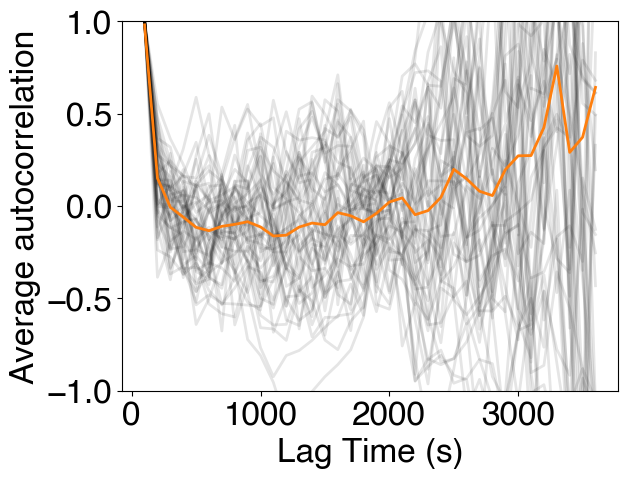

In [ ]:
data_path = Path.home() / 'Desktop/chromatin_mobility_data_Binyam.xlsx'
# Read in an excel file as a torch tensor
data = pd.read_excel(data_path, sheet_name='Chromatin spots AccuDis CytoD', header=0)

time_arr = torch.from_numpy(data['Time'].values[2:].astype(np.float64))
corr_avg = torch.zeros_like(time_arr[1:])
n_cells = 50
for n in range(1, n_cells):
    accu_arr = torch.from_numpy(data.iloc[2:,n].values.astype(np.float64))
    disp_arr = accu_arr[1:] - accu_arr[:-1]
    disp_mat = torch.einsum('i,j->ij', disp_arr, disp_arr)
    corr_arr = torch.zeros_like(disp_arr)
    for i in range(0, disp_mat.size(0)):
        corr_arr[i] = disp_mat.diag(i).mean()

    corr_arr = corr_arr[:]-torch.pow(disp_arr.mean(), 2)
    corr_arr = corr_arr/corr_arr[0]
    _ = plt.plot(time_arr[1:], corr_arr, alpha=.1, color='k')
    corr_avg += corr_arr

corr_avg /= n_cells

_ = plt.plot(time_arr[1:], corr_avg, color='tab:orange')
_ = plt.ylabel('Average autocorrelation')
_ = plt.xlabel('Lag Time (s)')
# _ = plt.ylim(-.5, .5)
_ = plt.ylim(-1, 1)
# _ = plt.yscale('log')
# _ = plt.xscale('log')
# # _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

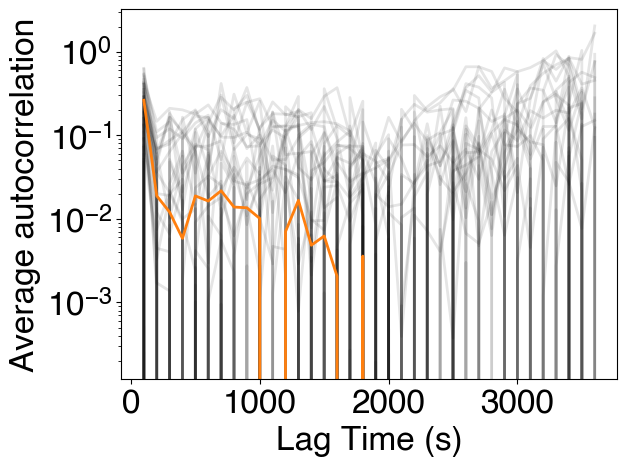

In [ ]:
data_path = Path.home() / 'Desktop/chromatin_mobility_data_Binyam.xlsx'
# Read in an excel file as a torch tensor
data = pd.read_excel(data_path, sheet_name='Chromatin spots AccuDis DMSO', header=0)

time_arr = torch.from_numpy(data['Time'].values[2:].astype(np.float64))
corr_avg = torch.zeros_like(time_arr[1:])
n_cells = 50
for n in range(1, n_cells):
    accu_arr = torch.from_numpy(data.iloc[2:,n].values.astype(np.float64))
    disp_arr = accu_arr[1:] - accu_arr[:-1]
    disp_mat = torch.einsum('i,j->ij', disp_arr, disp_arr)
    corr_arr = torch.zeros_like(disp_arr)
    for i in range(0, disp_mat.size(0)):
        corr_arr[i] = disp_mat.diag(i).mean()

    corr_arr = corr_arr[:]-torch.pow(disp_arr.mean(), 2)
    _ = plt.plot(time_arr[1:], corr_arr, alpha=.1, color='k')
    # corr_avg += corr_arr/corr_arr[0]
    corr_avg += corr_arr

corr_avg /= n_cells

_ = plt.plot(time_arr[1:], corr_avg, color='tab:orange')
_ = plt.ylabel('Average autocorrelation')
_ = plt.xlabel('Lag Time (s)')
_ = plt.yscale('log')
# _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

,Time,Accumulative displacement,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,N total,Mean,Standard Deviation
0,sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,DMSO_1,DMSO_2,DMSO_3,DMSO_4,DMSO_5,DMSO_6,DMSO_7,DMSO_8,DMSO_9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Statistics On Rows of B""Accumulative displacem...","Statistics On Rows of B""Accumulative displacem...","Statistics On Rows of B""Accumulative displacem..."
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50,0,0
3,100.153,1.34037,1.03121,1.40004,1.01247,1.08393,1.97378,1.03706,0.82134,2.01675,...,0.815414,0.580086,0.677422,0.681616,1.532351,0.652687,1.447273,50,1.006986,0.43871
4,200.147003,2.80164,1.99635,1.85666,2.55943,3.84389,4.10638,2.39864,1.75413,3.01344,...,3.382864,2.531829,1.290692,1.379111,2.787939,1.118090,3.238753,50,2.296907,0.796454
5,300.157013,4.62707,2.32054,2.88962,3.82252,4.81903,5.32215,4.32729,3.05321,4.59221,...,5.240739,3.494170,1.788487,2.038581,3.429343,2.328916,3.492722,50,3.544023,1.085236
6,400.088013,6.59362,4.20545,3.92321,5.89071,5.20387,5.50897,5.83822,4.49889,5.43114,...,6.592220,4.901224,2.422679,3.076897,4.959997,2.759381,4.285312,50,4.570328,1.230096
7,500.144989,7.79032,5.91852,4.9621,6.82377,6.06492,6.51902,7.82734,4.99909,7.26048,...,8.263208,5.638652,3.199145,3.448246,6.882833,3.199835,5.581846,50,5.744493,1.663636
8,600.107971,9.64191,7.76692,6.39998,8.71123,6.58232,7.20407,9.68739,6.86781,8.19744,...,9.201983,6.662419,4.694271,4.970776,8.639022,3.906518,6.420774,50,6.892758,1.899466
9,700.070007,12.14191,8.74529,8.47415,9.54316,8.78418,8.55555,13.08321,9.51347,9.6794,...,10.118989,7.419915,5.929220,5.784840,9.746542,4.645842,8.308047,50,8.127602,2.313284


In [7]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_DMSO_P2.xlsx'